In [1]:
import os
from preprocessing import Preprocessing, SplitAudio
import torchaudio

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
ruta_carpeta = "./MusicCaps"  # Reemplaza con la ruta real de tu carpeta

archivos = os.listdir(ruta_carpeta)

X = []
metadata = []
sample_rate_red = 16000
for archivo in archivos:
    waveform, samp_rt = torchaudio.load("./MusicCaps/" + archivo)
    f, s = SplitAudio(waveform, sample_rate = samp_rt, new_sample_rate = sample_rate_red)

    f_spec, f_maxi, f_mini = Preprocessing(f, 16000, resampler_f = False)
    s_spec, s_maxi, s_mini = Preprocessing(s, 16000, resampler_f = False)

    X += [f_spec, s_spec]
    metadata += [{"nombre":archivo, "parte":"first", "minimum":f_mini, "maximum":f_maxi},
                 {"nombre":archivo, "parte":"second", "minimum":s_mini, "maximum":s_maxi}]

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


# VISUALIZACIÓN PARA LA ENTREGA

Visualizacion de un espectograma cualquiera

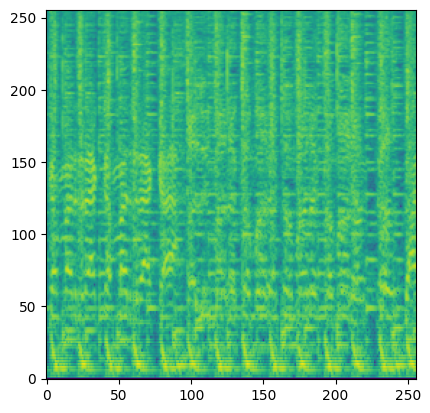

In [5]:
import matplotlib.pyplot as plt
plt.imshow(X[-5],origin='lower')

Visualización de estadísticos básicos de los espectogramas

Utilizando pairplot para que se cumplan los requisitos mínimos

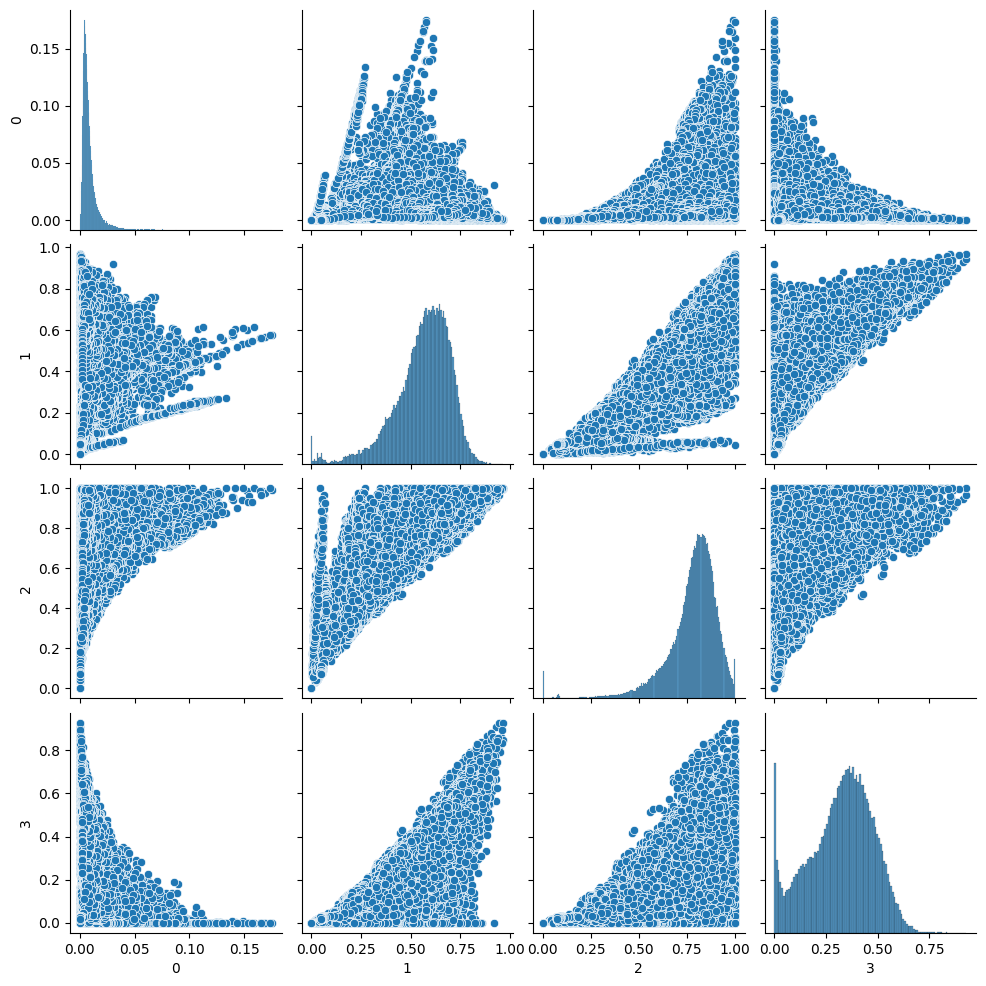

In [ ]:
import numpy as np

estadisticos = []
for i in X[:500]:
    for j in i:
        varianza = np.var(j.tolist(), axis=0)
        promedio = np.mean(j.tolist(), axis=0)
        maximo = np.max(j.tolist(), axis=0)
        minimo = np.min(j.tolist(), axis=0)
        estadisticos.append((varianza, promedio, maximo, minimo))

sns.pairplot(pd.DataFrame(estadisticos))
plt.show()

Visualización del t-SNE de la descomposición de los audios

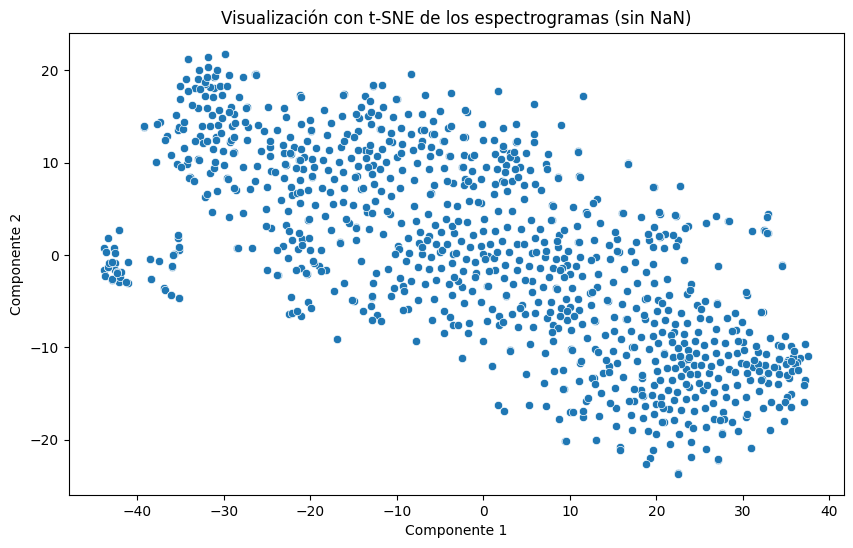

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Convertir lista de tensores a un tensor de PyTorch
X_tensor = torch.stack(X[:1000])  # (N, 256, 256)

# Reemplazar NaN con ceros
X_tensor = torch.nan_to_num(X_tensor, nan=0.0)

# Convertir a NumPy y aplanar los espectrogramas
X_numpy = X_tensor.numpy()
X_flat = X_numpy.reshape(X_numpy.shape[0], -1)  # (N, 65536)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_flat)  # (N, 2)

# Visualizar
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1])
plt.title("Visualización con t-SNE de los espectrogramas (sin NaN)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()
